# Merging segmentation masks
You can merge segmentation masks into one. The masks to be merged should always be ordererd by small to big. You can also add labels directly.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatialproteomics
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

In [3]:
ds = xr.load_dataset('../../data/BNHL_166_4_I2_LK.zarr').pp[1000:1300, 1000:1300]

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [8]:
# segmenting on CD11c (dendritic cells) and CD68 (macrophages) and getting the result as a numpy array
new_segmentations = ds.ext.cellpose(channels=['CD11c', 'CD68'], return_xarray=False, handle_disconnected="remove")

TORCH CUDA version not installed/working.
>>>> using CPU
>> cyto3 << model set to be used
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 19.10 sec
>>> diameter(s) = 
[ 20.95 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 34.51 sec
Found disconnected masks in the segmentation.
Removed 4 disconnected cells from the segmentation mask.
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 17.34 sec
>>> diameter(s) = 
[ 21.76 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 31.56 sec
Found disconnected masks in the segmentation.
Removed 1 disconnected cells from the segmentation mask.


In [10]:
new_segmentations.shape

(2, 301, 301)

In [11]:
ds

<xarray.Dataset>
Dimensions:        (cells: 314, channels: 56, y: 301, x: 301, labels: 8,
                    props: 2, features: 4)
Coordinates:
  * cells          (cells) int64 3185 3215 3236 3237 ... 4715 4718 4728 4729
  * channels       (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * features       (features) <U10 'centroid-0' 'centroid-1' ... '_original_'
  * labels         (labels) int64 1 2 3 4 5 6 7 8
  * props          (props) <U6 '_color' '_name'
  * x              (x) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * y              (y) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
Data variables:
    _arcsinh_mean  (cells, channels) float64 3.145 0.101 1.386 ... 0.7508 0.4342
    _arcsinh_sum   (cells, channels) float64 8.73 3.989 6.909 ... 5.641 5.032
    _image         (channels, y, x) uint8 72 72 72 69 79 92 109 ... 3 2 3 3 2 3
    _labels        (labels, props) object 'C3' ... 'B (PAX5)'
    _obs           (cells, features) float64 1.085e+03 1.296e+03 6.0 ... 4.0 3.0
    _raw_mean      (cells, channels) float64 57.93 0.5056 9.375 ... 4.117 2.24
    _raw_sum       (cells, channels) float64 1.547e+04 135.0 ... 704.0 383.0
    _segmentation  (y, x) int64 0 0 0 4319 4319 ... 4014 4014 3481 3481 3481

In [20]:
# merging the segmentation masks
merged_ds = ds.pp.merge_segmentation(new_segmentations, labels=['Dendritic Cell', 'Macrophage'])

Found disconnected masks in the segmentation.
Relabeled all cells to avoid disconnected cells.
Found 'cells' coordinate in '_arcsinh_mean'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_arcsinh_sum'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_obs'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_raw_mean'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_raw_sum'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'props' coordinate in '_labels'. Removing layer. Please re-add the layer after merging the segmentation masks.


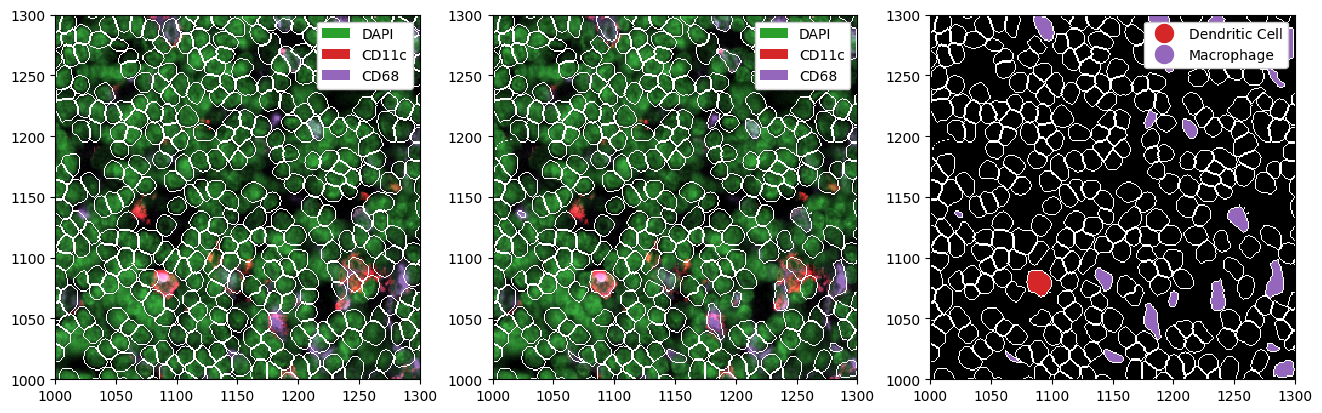

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# adding colors to match the channel colors
merged_ds = merged_ds.la.set_label_colors(['Dendritic Cell', 'Macrophage'], ['C3', 'C4'])

# original masks
_ = ds.pp[['DAPI', 'CD11c', 'CD68']].pl.colorize(colors=['C2', 'C3', 'C4']).pl.imshow(render_segmentation=True, legend_background=True, ax=ax[0])

# merged masks
_ = merged_ds.pp[['DAPI', 'CD11c', 'CD68']].pl.colorize(colors=['C2', 'C3', 'C4']).pl.imshow(render_segmentation=True, legend_background=True, ax=ax[1])
_ = merged_ds.pl.imshow(render_intensities=False, render_segmentation=True, render_labels=True, legend_label=True, ax=ax[2])


There are two issues right now: one is that the cellpose segmentation is suboptimal. We can try to fix this by setting different cell probability and flow probability thresholds in the cellpose method (see cellpose documentaiton for details). In addition, we can merge the segmentation masks with a lower cutoff. This will keep cells which retain more than threshold (e. g. 60) percent of their volume after the merging.

In [22]:
# segmenting on CD11c (dendritic cells) and CD68 (macrophages) and getting the result as a numpy array
new_segmentations = ds.ext.cellpose(channels=['CD11c', 'CD68'], cellprob_threshold=5.0, flow_threshold=0.4, return_xarray=False, handle_disconnected="remove")

TORCH CUDA version not installed/working.
>>>> using CPU
>> cyto3 << model set to be used
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 18.38 sec
>>> diameter(s) = 
[ 20.95 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 30.24 sec
Found disconnected masks in the segmentation.
Removed 1 disconnected cells from the segmentation mask.
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 16.91 sec
>>> diameter(s) = 
[ 21.76 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 30.13 sec
Found disconnected masks in the segmentation.
Removed 0 disconnected cells from the segmentation mask.


Text(0.5, 1.0, 'CD68')

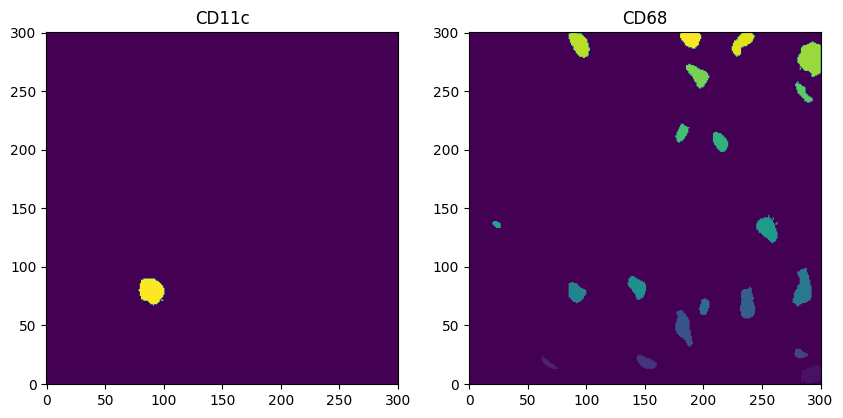

In [23]:
# inspecting the resulting segmentation masks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(new_segmentations[0])
ax[1].imshow(new_segmentations[1])

# flipping the y axis for consistency
ax[0].invert_yaxis()
ax[1].invert_yaxis()

ax[0].set_title('CD11c')
ax[1].set_title('CD68')

Found disconnected masks in the segmentation.
Relabeled all cells to avoid disconnected cells.
Found 'cells' coordinate in '_arcsinh_mean'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_arcsinh_sum'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_obs'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_raw_mean'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_raw_sum'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'props' coordinate in '_labels'. Removing layer. Please re-add the layer after merging the segmentation masks.


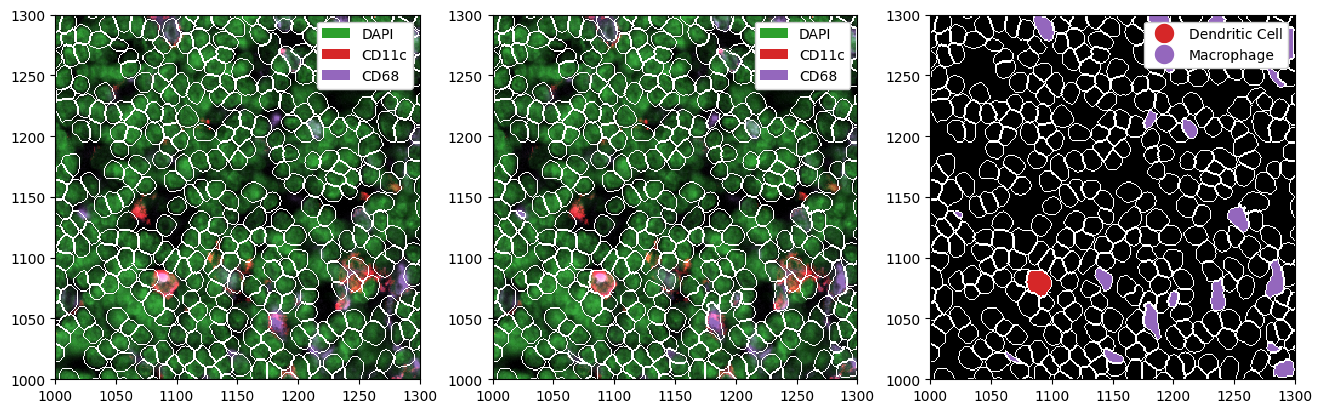

In [24]:
# merging the segmentation masks
merged_ds_2 = ds.pp.merge_segmentation(new_segmentations, labels=['Dendritic Cell', 'Macrophage'], threshold=0.6)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# adding colors to match the channel colors
merged_ds_2 = merged_ds_2.la.set_label_colors(['Dendritic Cell', 'Macrophage'], ['C3', 'C4'])

# original masks
_ = ds.pp[['DAPI', 'CD11c', 'CD68']].pl.colorize(colors=['C2', 'C3', 'C4']).pl.imshow(render_segmentation=True, legend_background=True, ax=ax[0])

# merged masks
_ = merged_ds_2.pp[['DAPI', 'CD11c', 'CD68']].pl.colorize(colors=['C2', 'C3', 'C4']).pl.imshow(render_segmentation=True, legend_background=True, ax=ax[1])
_ = merged_ds_2.pl.imshow(render_intensities=False, render_segmentation=True, render_labels=True, legend_label=True, ax=ax[2])

<xarray.Dataset>
Dimensions:        (labels: 6, props: 2, channels: 56, x: 301, y: 301,
                    cells: 361, features: 3, rgba: 4)
Coordinates:
  * labels         (labels) int64 1 2 3 4 5 6
  * props          (props) <U6 '_color' '_name'
  * channels       (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * x              (x) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * y              (y) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * cells          (cells) int64 1 2 3 4 5 6 7 8 ... 355 356 357 358 359 360 361
  * features       (features) <U10 '_labels' 'centroid-0' 'centroid-1'
  * rgba           (rgba) <U1 'r' 'g' 'b' 'a'
Data variables:
    _labels        (labels, props) object '#008941' 'Dendritic Cell' ... 'T'
    _image         (channels, y, x) uint8 72 72 72 69 79 92 109 ... 3 2 3 3 2 3
    _segmentation  (y, x) uint16 0 0 0 266 266 266 266 ... 192 192 192 61 61 61
    _obs           (cells, features) float64 1.0 1.079e+03 ... 1.058e+03
    _intensity     (cells, channels) float64 2.203e+04 0.0 ... 704.0 383.0
    _plot          (y, x, rgba) float32 0.0 0.0 0.0 1.0 ... 0.4039 0.6627 1.0

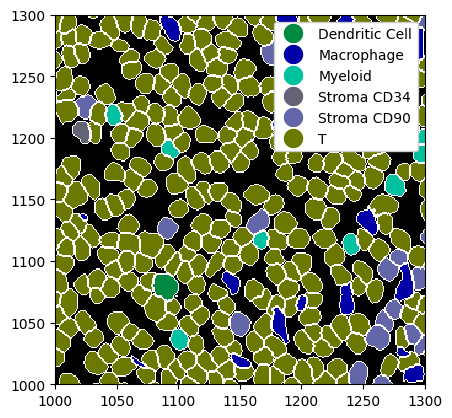

In [25]:
ct_dict = {
    "B": "PAX5",
    "T": "CD3",
    "Myeloid": "CD11b",
    # "Dendritic": "CD11c",
    "Granulo": "CD15",
    # "Macro": "CD68",
    "Stroma PDPN": "Podoplanin",
    "Stroma CD31": "CD31",
    "Stroma CD34": "CD34",
    "Stroma CD90": "CD90",
    "NK": "CD56",
}

merged_ds_2.pp.add_quantification().la.predict_cell_types_argmax(ct_dict).pl.imshow(render_intensities=False, render_segmentation=True, render_labels=True, legend_label=True)

<xarray.Dataset>
Dimensions:        (labels: 6, props: 2, channels: 56, x: 301, y: 301,
                    cells: 361, features: 3, rgba: 4)
Coordinates:
  * labels         (labels) int64 1 2 3 4 5 6
  * props          (props) <U6 '_color' '_name'
  * channels       (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * x              (x) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * y              (y) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * cells          (cells) int64 1 2 3 4 5 6 7 8 ... 355 356 357 358 359 360 361
  * features       (features) <U10 '_labels' 'centroid-0' 'centroid-1'
  * rgba           (rgba) <U1 'r' 'g' 'b' 'a'
Data variables:
    _image         (channels, y, x) uint8 72 72 72 69 79 92 109 ... 3 2 3 3 2 3
    _segmentation  (y, x) uint16 0 0 0 266 266 266 266 ... 192 192 192 61 61 61
    _obs           (cells, features) float64 1.0 1.079e+03 ... 1.058e+03
    _intensity     (cells, channels) float64 2.203e+04 0.0 ... 704.0 383.0
    _labels        (labels, props) object 'deepskyblue' 'Dendritic Cell' ... 'T'
    _plot          (y, x, rgba) float32 0.0 0.0 0.0 1.0 0.0 ... 1.0 1.0 0.0 1.0

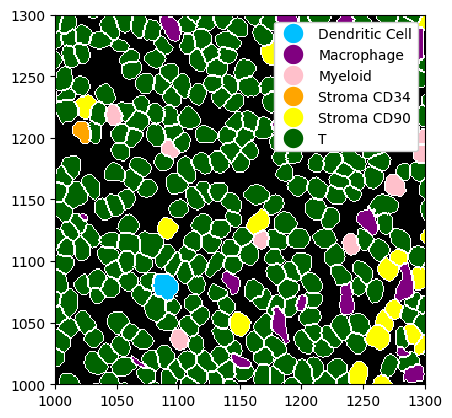

In [26]:
merged_ds_3 = merged_ds_2.pp.add_quantification().la.predict_cell_types_argmax(ct_dict)

color_dict = {"Dendritic Cell": "deepskyblue", "Macrophage": "purple", "Myeloid": "pink", "Stroma CD34": "orange", "Stroma CD90": "yellow", "T": "darkgreen"}
for k, v in color_dict.items():
    merged_ds_3 = merged_ds_3.la.set_label_colors(k, v)

merged_ds_3.pl.imshow(render_intensities=False, render_segmentation=True, render_labels=True, legend_label=True)